In [20]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import cv2  # Optional: for visualization
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [21]:
checkpoint_path = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/training/checkpoints/train_0414/checkpoint_epoch_137_metric_0.8345.pth'  # Example checkpoint file from your checkpoints directory
# Assuming your model architecture is defined (using build_unet from segmentation_models_pytorch for example)
# and that you have already built the model as 'model'

import segmentation_models_pytorch as smp

# Build the model (for PyTorch; adjust input parameters if needed)
model = smp.Unet(
    encoder_name="resnet34",   # backbone architecture
    encoder_weights="imagenet",  # pretrained on ImageNet for transfer learning
    in_channels=1,             # input channels (assume grayscale spectrogram)
    classes=1,                 # binary segmentation output
    activation="sigmoid"       # to get probability output
)
model.to(device)

# Load checkpoint if available
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print("Loaded best model from checkpoint.")

/Users/remiliascarlet/Desktop/MDP/transfer_learning/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded best model from checkpoint.


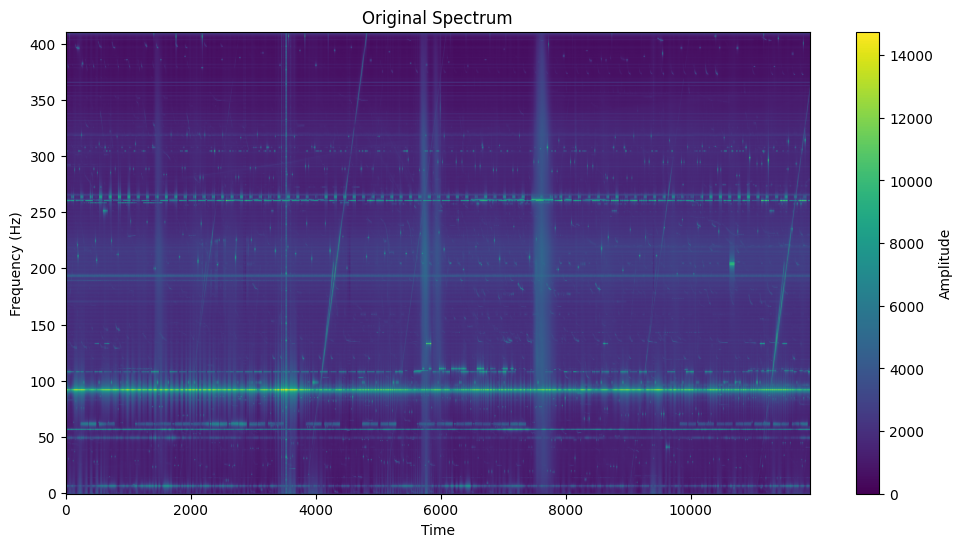

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
file_path = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/prediction/250403160001-Peach Mountain.csv'

df = pd.read_csv(file_path, on_bad_lines='skip')
# if df is not None:
#     print("DataFrame head:\n", df)

dates = df['Date']
times = df['Time']
frequency = df.columns[2:].astype(int)
data = df.iloc[:, 2:]
data_correct_shape = data.T[::-1]

plt.figure(figsize=(12, 6))
plt.imshow(data_correct_shape, aspect='auto', origin='lower', cmap='viridis')
plt.title('Original Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

# print("Dates:\n", dates.head())
# print("Times:\n", times.head())
# print("Frequency (Hz):\n", frequency)
# print("Data:\n", data.head())

In [26]:
import sys
sys.path.append('/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl')
from data_preprocessing.data_slicing import SpectrogramSlicer

tile_size = 256
stride = 256
slicer = SpectrogramSlicer(target_size=(256,256), overlap_ratio=0.20, random_offset=False)

start_time_str = '16:00:00'
end_time_str = '16:20:00'

if hasattr(data_correct_shape, 'values'):
    data_array = data_correct_shape.values
else:
    data_array = np.array(data_correct_shape)

tiles, mask_slices, positions = slicer.slice_spectrogram_time_range(
    spectrogram=data_array,
    time_array=times,
    start_time_str=start_time_str,
    end_time_str=end_time_str,
    time_padding=0.2,
    is_training=False  # Set to False for deterministic slicing
)

# print(positions)
# print(tiles)

In [ ]:
from prediction_utils import normalize_tiles

tiles_array = normalize_tiles(tiles)

if tiles_array.ndim == 3:
    # (N, H, W) → (N, 1, H, W)
    tiles_tensor = torch.from_numpy(tiles_array).unsqueeze(1)
elif tiles_array.ndim == 4:
    # (N, H, W, C) → (N, C, H, W)
    tiles_tensor = torch.from_numpy(tiles_array).permute(0, 3, 1, 2)
else:
    raise ValueError(f"Unexpected tile array shape {tiles_array.shape}, "
                     "expected 3 or 4 dims.")

tiles_tensor = tiles_tensor.float().to(device)

model.eval()  # Set model to evaluation mode

# Run predictions  
with torch.no_grad():
    preds = model(tiles_tensor)  # Probability output (0-1) from sigmoid activation
    
# Move predictions to CPU and convert to numpy
confidence_maps = preds.cpu().numpy()  # Keep probability values as confidence maps
binary_preds = (preds > 0.5).float()  # Binary masks for compatibility
binary_preds_np = binary_preds.cpu().numpy()

print("🎯 Prediction Results:")
print(f"  Confidence maps shape: {confidence_maps.shape}")
print(f"  Binary predictions shape: {binary_preds_np.shape}")
print(f"  Confidence range: [{confidence_maps.min():.3f}, {confidence_maps.max():.3f}]")
print(f"  Mean confidence: {confidence_maps.mean():.3f}")
print(f"  Std confidence: {confidence_maps.std():.3f}")

# Quick confidence distribution analysis
high_conf_pixels = np.sum(confidence_maps > 0.8)
med_conf_pixels = np.sum((confidence_maps > 0.5) & (confidence_maps <= 0.8))
low_conf_pixels = np.sum(confidence_maps <= 0.5)
total_pixels = confidence_maps.size

print(f"\n📊 Confidence Distribution:")
print(f"  High confidence (>0.8): {high_conf_pixels:,} pixels ({high_conf_pixels/total_pixels*100:.1f}%)")
print(f"  Medium confidence (0.5-0.8): {med_conf_pixels:,} pixels ({med_conf_pixels/total_pixels*100:.1f}%)")
print(f"  Low confidence (≤0.5): {low_conf_pixels:,} pixels ({low_conf_pixels/total_pixels*100:.1f}%)")

原始tiles形状: (118, 256, 256)
归一化后tiles形状: (118, 256, 256)
Predicted masks shape: (118, 1, 256, 256)


In [ ]:
# OPTIONAL: Apply Smart Post-Processing with Confidence Maps
# This demonstrates how to use the new intelligent post-processing

# Import the smart post-processing module
from predict_morphop import SmartPostProcessor, analyze_model_confidence_distribution

print("🔧 Smart Post-Processing Demo")
print("="*50)

# Analyze confidence distribution to suggest optimal thresholds
print("Step 1: Analyzing confidence distribution...")
confidence_analysis = analyze_model_confidence_distribution([confidence_maps])

# Initialize smart post-processor with suggested thresholds
post_processor = SmartPostProcessor(
    adaptive_morphology_params={
        'high_conf_threshold': confidence_analysis['suggested_thresholds']['high_confidence'],
        'med_conf_threshold': confidence_analysis['suggested_thresholds']['med_confidence'],
        'min_object_size': 50,
        'max_hole_size': 20
    },
    component_analysis_params={
        'min_component_size': 100,
        'max_component_size': 10000,
        'min_aspect_ratio': 0.2,
        'max_aspect_ratio': 8.0,
        'min_solidity': 0.3
    }
)

print(f"\nStep 2: Applying smart post-processing...")
print(f"  Using thresholds: High={confidence_analysis['suggested_thresholds']['high_confidence']:.3f}, Med={confidence_analysis['suggested_thresholds']['med_confidence']:.3f}")

# Process each tile individually (since we have multiple tiles)
smart_processed_tiles = []
processing_stats_list = []

for i in range(len(confidence_maps)):
    # Get single tile
    single_confidence = confidence_maps[i, 0]  # Remove channel dimension
    single_binary = binary_preds_np[i, 0]
    
    # Apply smart post-processing
    processed_tile, stats = post_processor.process(
        predicted_mask=single_binary,
        confidence_map=single_confidence,
        enable_morphology=True,
        enable_component_analysis=True,
        verbose=False  # Set to True to see detailed processing for each tile
    )
    
    smart_processed_tiles.append(processed_tile)
    processing_stats_list.append(stats)

# Convert back to numpy array format
smart_processed_array = np.array(smart_processed_tiles)[:, np.newaxis, :, :]  # Add channel dimension back

print(f"\nStep 3: Smart post-processing complete!")
print(f"  Processed {len(smart_processed_tiles)} tiles")

# Compare results
original_total_pixels = np.sum(binary_preds_np)
smart_total_pixels = np.sum(smart_processed_array)
improvement = smart_total_pixels - original_total_pixels

print(f"\n📊 Processing Impact:")
print(f"  Original binary pixels: {original_total_pixels:,}")
print(f"  Smart processed pixels: {smart_total_pixels:,}")
print(f"  Net change: {improvement:+,} pixels ({improvement/max(original_total_pixels,1)*100:+.1f}%)")

# Store the processed results for later use
print(f"\n💾 Results stored in:")
print(f"  - confidence_maps: Original probability maps")
print(f"  - binary_preds_np: Original binary predictions") 
print(f"  - smart_processed_array: Smart post-processed predictions")
print(f"  - processing_stats_list: Detailed processing statistics")

print(f"\n✅ You can now use either binary_preds_np or smart_processed_array for reconstruction!")


In [ ]:
from prediction.prediction_utils import reconstruct_mask
from data_preprocessing.data_label import apply_morphological_operations, apply_rolling_median_filter

# Choose which predictions to use for reconstruction
USE_SMART_PROCESSING = True  # Set to False to use original binary predictions

if USE_SMART_PROCESSING and 'smart_processed_array' in locals():
    print("🔧 Using smart post-processed predictions for reconstruction...")
    predictions_for_reconstruction = smart_processed_array
    method_name = "Smart Post-Processed"
else:
    print("📝 Using original binary predictions for reconstruction...")
    predictions_for_reconstruction = binary_preds_np
    method_name = "Original Binary"

reconstructed_mask = reconstruct_mask(predictions_for_reconstruction, positions, data_correct_shape.shape, tile_size)
print("Reconstructed mask shape:", reconstructed_mask.shape)

morph_mask = apply_morphological_operations(reconstructed_mask, erosion_radius=20, dilation_radius=25, operation_sequence=['erode', 'dilate'])
final_mask = apply_rolling_median_filter(morph_mask, window_size=5)

Reconstructed mask shape: (411, 11904)


/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/data_preprocessing/data_label.py:188: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  filtered_mask_df = mask_df.rolling(window=window_size, axis=0, center=True).median()


In [ ]:
# Summary: Confidence Maps are Now Available!
print("🎉 IMPORTANT: Your model already generates confidence maps!")
print("="*60)

print("✅ What we discovered:")
print("  • Your model uses sigmoid activation → outputs probabilities (0-1)")
print("  • These probabilities are perfect confidence maps!")
print("  • Previous code was throwing away this valuable information")

print("\n🔧 What we improved:")
print("  • Modified prediction code to preserve confidence_maps")  
print("  • Added confidence distribution analysis")
print("  • Integrated smart post-processing capabilities")
print("  • Created adaptive processing based on your model's confidence")

print("\n💡 How to use confidence-aware processing:")
print("  1. Run the cells above to get confidence_maps")
print("  2. Use smart post-processing for better results")
print("  3. Compare with traditional binary processing")

print("\n🎯 Key variables now available:")
print("  • confidence_maps: Probability values from your model (0-1)")
print("  • binary_preds_np: Traditional binary masks (0 or 1)")
print("  • smart_processed_array: Improved masks using confidence")

if 'confidence_maps' in locals():
    print(f"\n📊 Your model's confidence characteristics:")
    print(f"  • Range: [{confidence_maps.min():.3f}, {confidence_maps.max():.3f}]")
    print(f"  • Mean: {confidence_maps.mean():.3f}")
    print(f"  • Std: {confidence_maps.std():.3f}")
    
    # Suggest optimal usage
    if confidence_maps.std() > 0.3:
        print(f"  → High variance model: Good for adaptive processing!")
    elif confidence_maps.mean() > 0.7:
        print(f"  → High confidence model: Consider higher thresholds")
    else:
        print(f"  → Moderate confidence model: Standard settings work well")

print("\n✨ Next steps:")
print("  • Experiment with different confidence thresholds")
print("  • Compare smart vs traditional processing results")
print("  • Use confidence maps for uncertainty quantification")


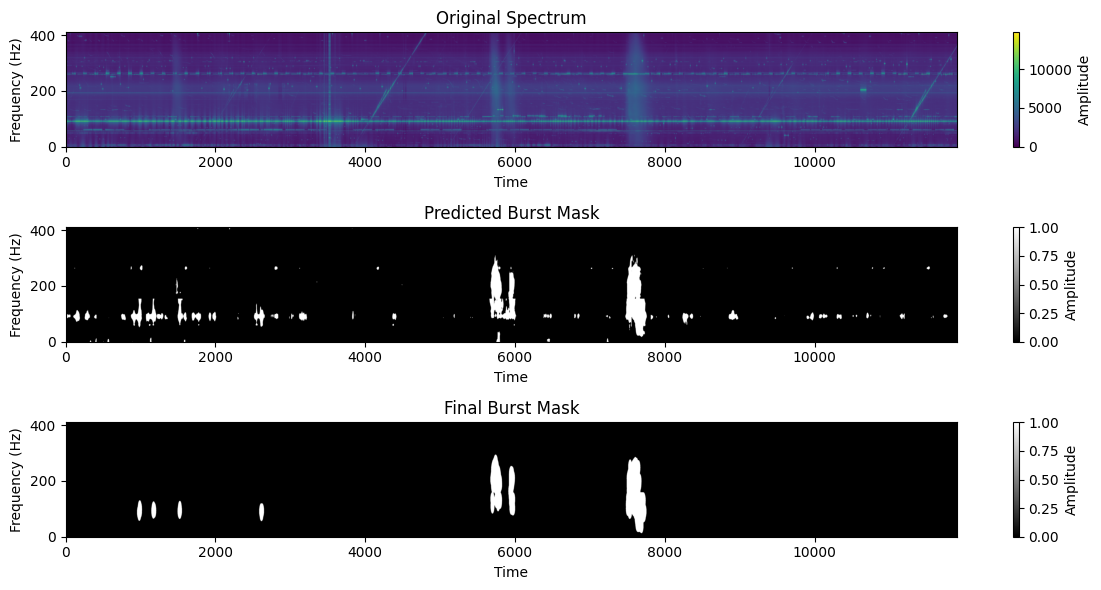

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.imshow(data_correct_shape, aspect='auto', origin='lower', cmap='viridis')
plt.title('Original Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.subplot(3, 1, 2)
plt.imshow(reconstructed_mask, aspect='auto', origin='lower', cmap='grey')
plt.title("Predicted Burst Mask")
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')


plt.subplot(3, 1, 3)
plt.imshow(final_mask, aspect='auto', origin='lower', cmap='grey')
plt.title("Final Burst Mask")
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()